Starting Digital Forensic Video Analysis...
Analyzing: sample_video.mp4

Step 1: Extracting video metadata...

Step 2: Capturing video frames...
Extracted 1503 frames from video

Step 3: Detecting duplicate frames...
Computing frame hashes using perceptual method...
Found 1424 duplicate/similar frames

Step 4: Generating forensic report...
Found 10 suspicious frame transitions
Found 10 suspicious frame transitions
Found 10 suspicious frame transitions
Found 10 suspicious frame transitions

Step 5: Visualizing duplicate frames...
Duplicate frames visualization saved as 'duplicate_frames.png'


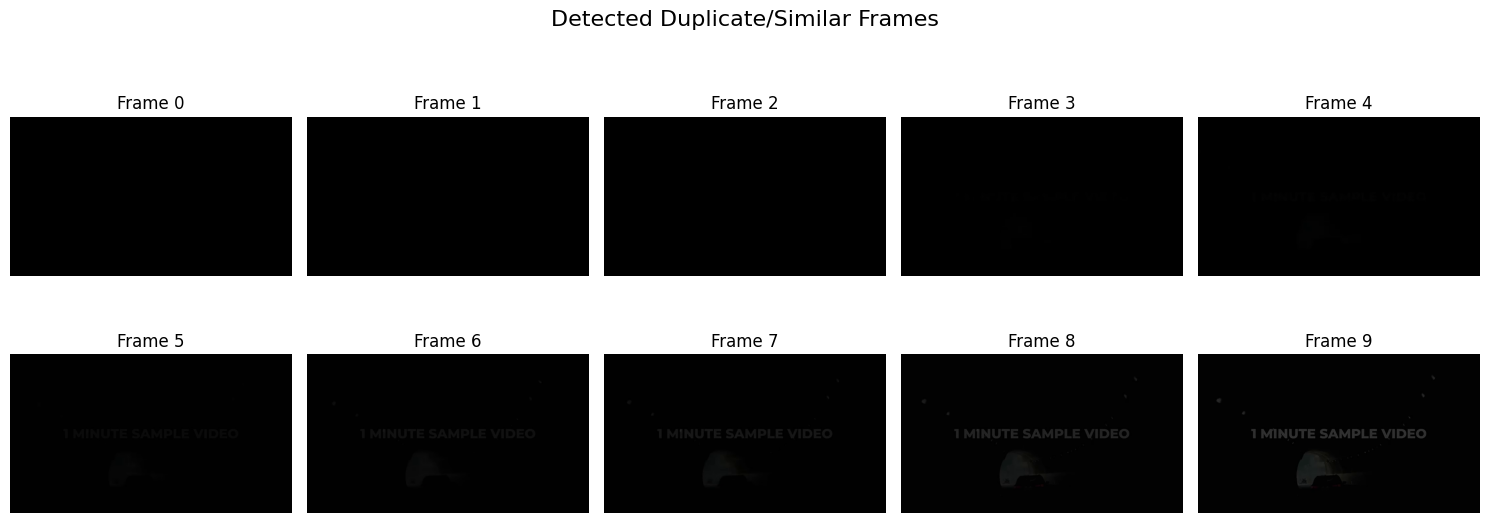


DIGITAL FORENSIC VIDEO ANALYSIS REPORT

--- VIDEO METADATA ---
Filename: sample_video.mp4
File Size: 4501624
Frame Count: 1506
Fps: 25.02
Width: 854
Height: 480
Codec: 875967080
Duration: 60.19184652278177
Analysis Date: 2025-11-18 17:03:44

--- FORENSIC ANALYSIS ---
Total Frames Analyzed: 1503
Duplicate Frames: 1424 (94.74%)
Suspicious Transitions: 10
Authenticity Score: 41.58/100

--- COMPRESSION ANALYSIS ---
Mean Sharpness: 778.50
Std Sharpness: 764.95
Min Sharpness: 0.00
Max Sharpness: 2014.55

--- RECOMMENDATIONS ---
1. High number of duplicate frames detected. Video may contain static segments or tampering.
2. Suspicious frame transitions detected. Possible frame deletion or splicing.
3. Low authenticity score. Further manual inspection recommended.

Forensic report saved to forensic_report.json

Analysis complete!


In [1]:
import cv2
import numpy as np
import hashlib
import matplotlib.pyplot as plt
from collections import Counter
import json
from datetime import datetime
import os

class VideoForensicTool:

    def __init__(self, video_path):

        self.video_path = video_path
        self.frames = []
        self.frame_hashes = []
        self.duplicate_frames = []
        self.metadata = {}
        self.analysis_report = {}

    def extract_metadata(self):

        cap = cv2.VideoCapture(self.video_path)

        self.metadata = {
            'filename': os.path.basename(self.video_path),
            'file_size': os.path.getsize(self.video_path),
            'frame_count': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
            'fps': cap.get(cv2.CAP_PROP_FPS),
            'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
            'codec': int(cap.get(cv2.CAP_PROP_FOURCC)),
            'duration': cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS),
            'analysis_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        cap.release()
        return self.metadata

    def capture_frames(self):

        cap = cv2.VideoCapture(self.video_path)

        if not cap.isOpened():
            raise ValueError(f"Error: Cannot open video file {self.video_path}")

        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            self.frames.append(frame)
            frame_count += 1

        cap.release()
        print(f"Extracted {frame_count} frames from video")
        return frame_count

    def compute_frame_hash(self, frame, hash_size=8):

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        resized = cv2.resize(gray, (hash_size + 1, hash_size))

        diff = resized[:, 1:] > resized[:, :-1]

        hash_value = sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

        return format(hash_value, f'0{hash_size*hash_size}b')

    def compute_md5_hash(self, frame):

        return hashlib.md5(frame.tobytes()).hexdigest()

    def detect_duplicates(self, method='perceptual', threshold=5):

        print(f"Computing frame hashes using {method} method...")

        if method == 'exact':
            self.frame_hashes = [self.compute_md5_hash(frame) for frame in self.frames]
        else:
            self.frame_hashes = [self.compute_frame_hash(frame) for frame in self.frames]

        duplicate_groups = {}
        seen = {}

        for idx, hash_val in enumerate(self.frame_hashes):
            if method == 'exact':
                if hash_val in seen:
                    if hash_val not in duplicate_groups:
                        duplicate_groups[hash_val] = [seen[hash_val]]
                    duplicate_groups[hash_val].append(idx)
                else:
                    seen[hash_val] = idx
            else:
                for prev_idx, prev_hash in enumerate(self.frame_hashes[:idx]):
                    hamming_dist = self.hamming_distance(hash_val, prev_hash)
                    if hamming_dist <= threshold:
                        key = f"{prev_idx}_{idx}"
                        if prev_hash not in duplicate_groups:
                            duplicate_groups[prev_hash] = [prev_idx]
                        if idx not in duplicate_groups[prev_hash]:
                            duplicate_groups[prev_hash].append(idx)

        self.duplicate_frames = []
        for group in duplicate_groups.values():
            self.duplicate_frames.extend(group)

        self.duplicate_frames = sorted(list(set(self.duplicate_frames)))

        print(f"Found {len(self.duplicate_frames)} duplicate/similar frames")
        return self.duplicate_frames

    def hamming_distance(self, hash1, hash2):

        return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))

    def detect_frame_deletion(self):

        suspicious_transitions = []

        for i in range(1, len(self.frames) - 1):
            diff_prev = cv2.absdiff(cv2.cvtColor(self.frames[i-1], cv2.COLOR_BGR2GRAY),
                                   cv2.cvtColor(self.frames[i], cv2.COLOR_BGR2GRAY))
            diff_next = cv2.absdiff(cv2.cvtColor(self.frames[i], cv2.COLOR_BGR2GRAY),
                                   cv2.cvtColor(self.frames[i+1], cv2.COLOR_BGR2GRAY))

            mean_diff_prev = np.mean(diff_prev)
            mean_diff_next = np.mean(diff_next)

            if mean_diff_next > 2 * mean_diff_prev and mean_diff_next > 50:
                suspicious_transitions.append({
                    'frame_index': i,
                    'timestamp': i / self.metadata['fps'],
                    'diff_magnitude': float(mean_diff_next)
                })

        print(f"Found {len(suspicious_transitions)} suspicious frame transitions")
        return suspicious_transitions

    def analyze_compression_artifacts(self, sample_size=10):

        if len(self.frames) < sample_size:
            sample_size = len(self.frames)

        indices = np.linspace(0, len(self.frames) - 1, sample_size, dtype=int)

        compression_scores = []

        for idx in indices:
            frame = self.frames[idx]
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            compression_scores.append(laplacian_var)

        return {
            'mean_sharpness': float(np.mean(compression_scores)),
            'std_sharpness': float(np.std(compression_scores)),
            'min_sharpness': float(np.min(compression_scores)),
            'max_sharpness': float(np.max(compression_scores))
        }

    def visualize_duplicates(self, max_display=10):

        if not self.duplicate_frames:
            print("No duplicate frames to display")
            return

        num_display = min(max_display, len(self.duplicate_frames))

        fig, axes = plt.subplots(2, (num_display + 1) // 2, figsize=(15, 6))
        fig.suptitle('Detected Duplicate/Similar Frames', fontsize=16)

        axes = axes.flatten()

        for i, frame_idx in enumerate(self.duplicate_frames[:num_display]):
            frame_rgb = cv2.cvtColor(self.frames[frame_idx], cv2.COLOR_BGR2RGB)
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f'Frame {frame_idx}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.savefig('duplicate_frames.png', dpi=150, bbox_inches='tight')
        print("Duplicate frames visualization saved as 'duplicate_frames.png'")
        plt.show()

    def generate_forensic_report(self):

        suspicious_transitions = self.detect_frame_deletion()

        compression_analysis = self.analyze_compression_artifacts()

        self.analysis_report = {
            'metadata': self.metadata,
            'total_frames': len(self.frames),
            'duplicate_frames': {
                'count': len(self.duplicate_frames),
                'percentage': (len(self.duplicate_frames) / len(self.frames)) * 100 if self.frames else 0,
                'indices': self.duplicate_frames
            },
            'suspicious_transitions': {
                'count': len(suspicious_transitions),
                'details': suspicious_transitions
            },
            'compression_analysis': compression_analysis,
            'authenticity_score': self.calculate_authenticity_score(),
            'recommendations': self.generate_recommendations()
        }

        return self.analysis_report

    def calculate_authenticity_score(self):

        score = 100.0

        if self.frames:
            duplicate_ratio = len(self.duplicate_frames) / len(self.frames)
            score -= duplicate_ratio * 30

        suspicious_count = len(self.detect_frame_deletion())
        score -= min(suspicious_count * 5, 30)

        return max(0.0, min(100.0, score))

    def generate_recommendations(self):

        recommendations = []

        if len(self.duplicate_frames) > len(self.frames) * 0.1:
            recommendations.append("High number of duplicate frames detected. Video may contain static segments or tampering.")

        if len(self.detect_frame_deletion()) > 5:
            recommendations.append("Suspicious frame transitions detected. Possible frame deletion or splicing.")

        if self.calculate_authenticity_score() < 70:
            recommendations.append("Low authenticity score. Further manual inspection recommended.")

        if not recommendations:
            recommendations.append("No major anomalies detected. Video appears authentic.")

        return recommendations

    def save_report(self, filename='forensic_report.json'):

        with open(filename, 'w') as f:
            json.dump(self.analysis_report, f, indent=4)

        print(f"Forensic report saved to {filename}")

    def print_report(self):

        print("\n" + "="*60)
        print("DIGITAL FORENSIC VIDEO ANALYSIS REPORT")
        print("="*60)

        print("\n--- VIDEO METADATA ---")
        for key, value in self.metadata.items():
            print(f"{key.replace('_', ' ').title()}: {value}")

        print("\n--- FORENSIC ANALYSIS ---")
        print(f"Total Frames Analyzed: {self.analysis_report['total_frames']}")
        print(f"Duplicate Frames: {self.analysis_report['duplicate_frames']['count']} "
              f"({self.analysis_report['duplicate_frames']['percentage']:.2f}%)")
        print(f"Suspicious Transitions: {self.analysis_report['suspicious_transitions']['count']}")
        print(f"Authenticity Score: {self.analysis_report['authenticity_score']:.2f}/100")

        print("\n--- COMPRESSION ANALYSIS ---")
        for key, value in self.analysis_report['compression_analysis'].items():
            print(f"{key.replace('_', ' ').title()}: {value:.2f}")

        print("\n--- RECOMMENDATIONS ---")
        for i, rec in enumerate(self.analysis_report['recommendations'], 1):
            print(f"{i}. {rec}")

        print("\n" + "="*60)


def main():

    video_path = 'sample_video.mp4'

    print("Starting Digital Forensic Video Analysis...")
    print(f"Analyzing: {video_path}\n")

    forensic_tool = VideoForensicTool(video_path)

    print("Step 1: Extracting video metadata...")
    forensic_tool.extract_metadata()

    print("\nStep 2: Capturing video frames...")
    forensic_tool.capture_frames()

    print("\nStep 3: Detecting duplicate frames...")
    forensic_tool.detect_duplicates(method='perceptual', threshold=5)

    print("\nStep 4: Generating forensic report...")
    forensic_tool.generate_forensic_report()

    print("\nStep 5: Visualizing duplicate frames...")
    forensic_tool.visualize_duplicates(max_display=10)

    forensic_tool.print_report()
    forensic_tool.save_report('forensic_report.json')

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()